#### Import functions from other file

In [1]:
# all core functions used in this file are defined in th myFunctions file
%run myFunctions.ipynb

### Read in May data

In [2]:
# csv file was filled with data from the SQL found in the appendix at the end of the file
# read data from the csv
may_df = pd.read_csv('may_df.csv', index_col = False)

# drop the unnecessary index column
may_df.drop('Unnamed: 0', axis=1, inplace=True)

# understand our dataset now that we have pulled in the data
print(len(may_df))
print(may_df.dtypes)
may_df.head(2)

5947816
CLIENT_ID                        object
MONTH                            object
MOST_WATCHED_CHANNEL             object
MOST_WATCHED_CATEGORY            object
TOTAL_TVMS                      float64
USER_STATUS                      object
LINEAR_TVMS                     float64
VOD_TVMS                        float64
ADDTOWATCHLIST_FLAG             float64
FAVORITECHANNEL_FLAG            float64
SEARCHSTART_FLAG                float64
LIVEL2NAV_FLAG                  float64
VODL2NAV_FLAG                   float64
WATCHNOW_FLAG                   float64
BACKTOGUIDE_FLAG                float64
FEATURE_FLAG                    float64
TENURE_DAYS                     float64
AVG_DAYS_APART                  float64
AVG_SESSION_DURATION            float64
MONTHLY_AVG_SESSION_DURATION    float64
FREQUENCY                       float64
MONTHLY_FREQUENCY               float64
UNIQUE_DAYS                     float64
DAY_PERCENT                     float64
dtype: object


,CLIENT_ID,MONTH,MOST_WATCHED_CHANNEL,MOST_WATCHED_CATEGORY,TOTAL_TVMS,USER_STATUS,LINEAR_TVMS,VOD_TVMS,ADDTOWATCHLIST_FLAG,FAVORITECHANNEL_FLAG,...,BACKTOGUIDE_FLAG,FEATURE_FLAG,TENURE_DAYS,AVG_DAYS_APART,AVG_SESSION_DURATION,MONTHLY_AVG_SESSION_DURATION,FREQUENCY,MONTHLY_FREQUENCY,UNIQUE_DAYS,DAY_PERCENT
0,90f4ffe9-6a5f-51fa-993c-6c19a83aad44,2022-05-01,Pluto TV Horror,Movies,92.75,Return User,92.75,0.00,0.00,0.00,...,0.00,0.00,173.00,34.00,46.60,92.75,2.00,1.00,2.00,0.06
1,90f50165-1f5a-52fa-b736-8273eedec093,2022-05-01,Pluto TV Comedy,Movies,411.47,Return User,411.47,0.00,0.00,0.00,...,1.00,1.00,143.00,2.44,263.73,82.29,38.00,5.00,4.00,0.13


In [8]:
# rename columns for clarity later
may_df.rename(columns = {'AVG_SESSION_DURATION':'OVERALL_AVG_SESSION_DURATION','MONTHLY_AVG_SESSION_DURATION':'AVG_SESSION_DURATION', 'FREQUENCY':'OVERALL_SESSION_FREQUENCY', 'MONTHLY_FREQUENCY':'SESSION_FREQUENCY'}, inplace = True)

# confirm column rename was correct and worked
may_df.columns

Index(['CLIENT_ID', 'MONTH', 'MOST_WATCHED_CHANNEL', 'MOST_WATCHED_CATEGORY',
       'TOTAL_TVMS', 'USER_STATUS', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'TENURE_DAYS', 'AVG_DAYS_APART',
       'OVERALL_AVG_SESSION_DURATION', 'AVG_SESSION_DURATION',
       'OVERALL_SESSION_FREQUENCY', 'SESSION_FREQUENCY', 'UNIQUE_DAYS',
       'DAY_PERCENT', 'log_transform_TOTAL_TVMS'],
      dtype='object')

### Exploring May data

In [3]:
# how many available TVMs are there in May
total_possible_may_tvms = 31*24*60

# how many users have more TVMs than should be possible
print('Over the possible TVMs: ',may_df[may_df['TOTAL_TVMS'] > total_possible_may_tvms]['CLIENT_ID'].nunique())
print('0 TVMs: ',may_df[may_df['TOTAL_TVMS'] == 0]['CLIENT_ID'].nunique())

Over the possible TVMs:  3
0 TVMs:  464


## Transforming TVMs

In [4]:
# TVMs are very heavily skewed so we need to transform them for the analysis
# the 'transforming_columns' function is defined in the myFunctions file
may_df = transforming_columns(may_df,['TOTAL_TVMS'])

In [10]:
# lets remove any users above 44,640 since it should be technically impossible to have that many TVMs 
    # and there are only 3 of theses users
# lets remove any users with a TVM value of 0 since we get a negative infinity value for those users when we do a log transform 
    # and there are only 464 users with a 0 TVM value out of the 5.9 million users in the dataframe
may_df1 = may_df[(may_df['TOTAL_TVMS'] != 0) & (may_df['TOTAL_TVMS'] < total_possible_may_tvms)].copy()

# confirm the new df looks good
print(len(may_df1))
print(may_df1.columns)

5947349
Index(['CLIENT_ID', 'MONTH', 'MOST_WATCHED_CHANNEL', 'MOST_WATCHED_CATEGORY',
       'TOTAL_TVMS', 'USER_STATUS', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'TENURE_DAYS', 'AVG_DAYS_APART',
       'OVERALL_AVG_SESSION_DURATION', 'AVG_SESSION_DURATION',
       'OVERALL_SESSION_FREQUENCY', 'SESSION_FREQUENCY', 'UNIQUE_DAYS',
       'DAY_PERCENT', 'log_transform_TOTAL_TVMS'],
      dtype='object')


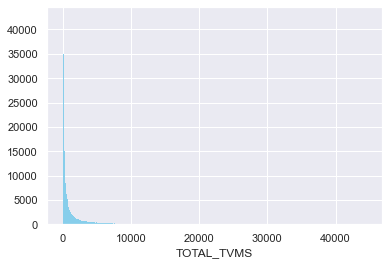

In [6]:
histogram_printing(may_df1,column = 'TOTAL_TVMS',bins = 10000,ylim_list = [0,total_possible_may_tvms])

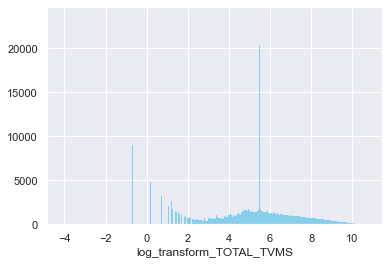

In [14]:
histogram_printing(may_df1,column = 'log_transform_TOTAL_TVMS',bins = 10000)

# Multidimensional Clustering

### Raw segmentation on the following variables:
- Session Frequency 
- Daily Frequency
- VOD TVMs
- ASD
- Total TVMs

In [11]:
# Creating a dataframe with only the necessary data points for clustering
sesfreq_Day_VOD_ASD_TVM_df = may_df1[['CLIENT_ID','SESSION_FREQUENCY','UNIQUE_DAYS','VOD_TVMS','AVG_SESSION_DURATION','log_transform_TOTAL_TVMS','TOTAL_TVMS']]

# confirm it looks good
sesfreq_Day_VOD_ASD_TVM_df.head(1)

,CLIENT_ID,SESSION_FREQUENCY,UNIQUE_DAYS,VOD_TVMS,AVG_SESSION_DURATION,log_transform_TOTAL_TVMS,TOTAL_TVMS
0,90f4ffe9-6a5f-51fa-993c-6c19a83aad44,1.00,2.00,0.00,92.75,4.53,92.75


In [12]:
# Scaling the data to ensure proper weighting for the clustering
# the 'scale_' function is defined in the myFunctions file
scaled_data1 = scale_(sesfreq_Day_VOD_ASD_TVM_df[['log_transform_TOTAL_TVMS','AVG_SESSION_DURATION','SESSION_FREQUENCY','VOD_TVMS','UNIQUE_DAYS']])

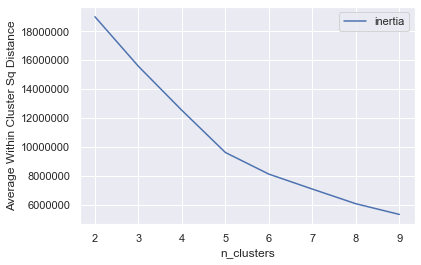

In [19]:
# elbow plot on a range of cluster sizes to see where diminishing returns begin
# 'elbow_plot' function defined in myFunctions
elbow_plot(min_cluster = 2,max_cluster = 10,scaled_data = scaled_data1)

In [13]:
# now that we see that diminishing returns begins around 5 and 6 lets run a clustering on 5 and 6
# 'clustering' function is defined in myFunctions file
sesfreq_Day_VOD_ASD_TVM_df = clustering(sesfreq_Day_VOD_ASD_TVM_df,cluster_amounts = [5,6],scaled_data = scaled_data1)

In [22]:
# lets look at information around the clusters
# 'description_ver2' function is defined in myFunctions file
describe5 = description_ver2(sesfreq_Day_VOD_ASD_TVM_df,column = ['TOTAL_TVMS','SESSION_FREQUENCY','AVG_SESSION_DURATION','VOD_TVMS','UNIQUE_DAYS'],cluster_value = 5)

# lets just look at the following columns from the describe as they are the 'most' important
describe5[['count', 'min','mean','max','index','percent', 'variable']]

,count,min,mean,max,index,percent,variable
kmeans_5_color,,,,,,,
black,984.00,"7,273.53","14,370.35","44,588.17",149.12,0.02,AVG_SESSION_DURATION
black,984.00,1.00,2.79,6.00,0.34,0.02,SESSION_FREQUENCY
black,984.00,"7,273.53","33,360.67","44,588.17",29.36,0.02,TOTAL_TVMS
black,984.00,1.00,24.82,31.00,4.47,0.02,UNIQUE_DAYS
black,984.00,0.00,318.45,"21,611.02",2.99,0.02,VOD_TVMS
purple,"30,944.00",13.97,283.18,"8,538.85",2.94,0.52,AVG_SESSION_DURATION
purple,"30,944.00",1.00,39.20,597.00,4.84,0.52,SESSION_FREQUENCY
purple,"30,944.00","2,719.32","9,330.95","44,050.38",8.21,0.52,TOTAL_TVMS
purple,"30,944.00",2.00,21.43,31.00,3.86,0.52,UNIQUE_DAYS


In [23]:
# this is the same as above just looking at the 6 cluster rather than 5 so that we can compare and determine which is better
describe6 = description_ver2(sesfreq_Day_VOD_ASD_TVM_df,column = ['TOTAL_TVMS','SESSION_FREQUENCY','AVG_SESSION_DURATION','VOD_TVMS','UNIQUE_DAYS'],cluster_value = 6)

# again only looking at the 'most' important fields from the describe
describe6[['count', 'min','mean','max','index','percent', 'variable']]

,count,min,mean,max,index,percent,variable
kmeans_6_color,,,,,,,
green,983.00,"7,279.85","14,377.57","44,588.17",149.19,0.02,AVG_SESSION_DURATION
green,983.00,1.00,2.79,6.00,0.34,0.02,SESSION_FREQUENCY
green,983.00,"7,279.85","33,387.20","44,588.17",29.39,0.02,TOTAL_TVMS
green,983.00,1.00,24.83,31.00,4.47,0.02,UNIQUE_DAYS
green,983.00,0.00,318.77,"21,611.02",3.00,0.02,VOD_TVMS
black,"28,554.00",15.62,287.67,"8,538.85",2.99,0.48,AVG_SESSION_DURATION
black,"28,554.00",1.00,39.67,597.00,4.90,0.48,SESSION_FREQUENCY
black,"28,554.00","2,837.55","9,563.38","44,050.38",8.42,0.48,TOTAL_TVMS
black,"28,554.00",3.00,21.73,31.00,3.91,0.48,UNIQUE_DAYS


### PCA on the same 5 variables:
- Session Frequency 
- Daily Frequency
- VOD TVMs
- ASD
- Total TVMs

In [14]:
# repeating the scaling of the data, treating this like its own section with each step
scaled_data1 = scale_(sesfreq_Day_VOD_ASD_TVM_df[['log_transform_TOTAL_TVMS','AVG_SESSION_DURATION','SESSION_FREQUENCY','VOD_TVMS','UNIQUE_DAYS']])

In [15]:
# start by defining pca without a set number of components since we dont know the ideal number of components yet
pca = PCA()

# fit the scaled data to the pca to get the variance ratio to determine ideal number of clusters
pca.fit(scaled_data1)

# view the actual variance ratio values before we plot them below
pca.explained_variance_ratio_

array([0.52093178, 0.19743978, 0.1788066 , 0.08246856, 0.02035328])

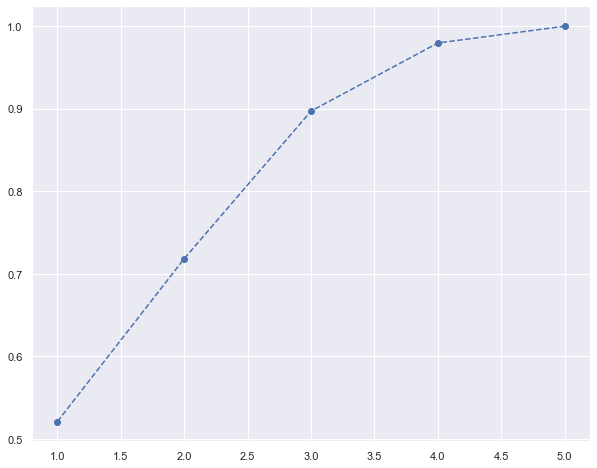

In [16]:
# plot the variance ratios with cumulative sum to see 
   # how many components we need to use to achieve the desired percentage of variance
plt.figure(figsize = (10,8))
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')

In [17]:
# 3 components gives us nearly 90% variance so lets redo the PCA with 3 components
pca = PCA(n_components = 3)

# lets refit the scaled data with 3 components set
pca.fit(scaled_data1)

PCA(n_components=3)

In [18]:
# Lets look at the component composition as well in a nice dataframe format
component_comp_df = pd.DataFrame(abs(pca.components_),columns = ['log_transform_TOTAL_TVMS','AVG_SESSION_DURATION','SESSION_FREQUENCY','VOD_TVMS','UNIQUE_DAYS'])

# output it
component_comp_df

,log_transform_TOTAL_TVMS,AVG_SESSION_DURATION,SESSION_FREQUENCY,VOD_TVMS,UNIQUE_DAYS
0,0.51,0.21,0.55,0.25,0.58
1,0.12,0.90,0.31,0.18,0.20
2,0.13,0.23,0.09,0.95,0.12


In [19]:
# next we gather our PCA scores 
scores_pca = pca.transform(scaled_data1)

In [20]:
# now we concat the original dataframe that has the 5 variables we used as well as the descriptor 
    # variables with the PCA components otherwise defined as the PCA scores
full_df_segm_pca_kmeans = pd.concat([may_df1.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)

# we can rename those PCA scores to their proper names of component 1 - 3
full_df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1','Component 2','Component 3']

# lets check the dataframe to make sure everything we did looks good
full_df_segm_pca_kmeans.head(1)
print(full_df_segm_pca_kmeans.columns)

# we will use this dataframe later for adding in the clustering labels

Index(['CLIENT_ID', 'MONTH', 'MOST_WATCHED_CHANNEL', 'MOST_WATCHED_CATEGORY',
       'TOTAL_TVMS', 'USER_STATUS', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'TENURE_DAYS', 'AVG_DAYS_APART',
       'OVERALL_AVG_SESSION_DURATION', 'AVG_SESSION_DURATION',
       'OVERALL_SESSION_FREQUENCY', 'SESSION_FREQUENCY', 'UNIQUE_DAYS',
       'DAY_PERCENT', 'log_transform_TOTAL_TVMS', 'Component 1', 'Component 2',
       'Component 3'],
      dtype='object')


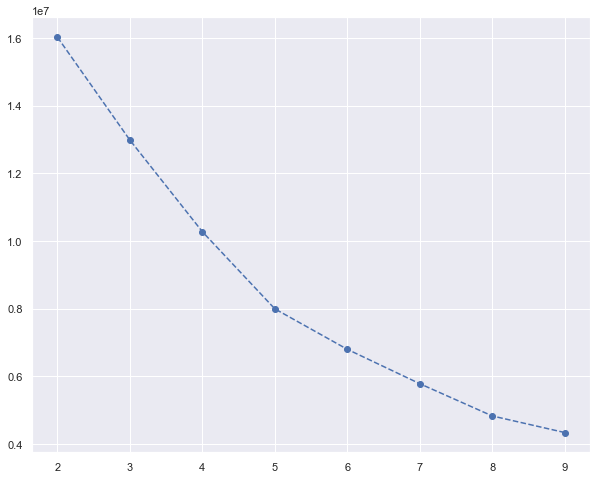

In [31]:
# now we are going to find the ideal number of clusters for the k-means clustering off of the pca scores 
# by running the clustering on a range of values to generate an elbow plot to see where we have diminishing returns
temp = []
for i in range(2,10):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
    kmeans_pca.fit(scores_pca)
    temp.append(kmeans_pca.inertia_)

# elbow plot generation
plt.figure(figsize = (10,8))
plt.plot(range(2,10), temp, marker = 'o', linestyle = '--')
plt.show()

### 5 clustering

In [34]:
# as we see in the elbow plot above the returns begin to diminish at 5 and 6 so we run the clustering on 5 for comparison to 6
kmeans_pca5 = KMeans(n_clusters = 5, init = 'k-means++', random_state = 10)

# now we fit the pca scores to the clustering now that we defined it above
kmeans_pca5.fit(scores_pca)

# now we can add in the clustering values to the full dataframe with our variables and descriptors
full_df_segm_pca_kmeans['Segment K-Means PCA 5'] = kmeans_pca5.labels_

# lets confirm the dataframe is looking good with all our variables, all our descriptors, our  3 components and 5 and 6 clusters
full_df_segm_pca_kmeans.columns

Index(['CLIENT_ID', 'MONTH', 'MOST_WATCHED_CHANNEL', 'MOST_WATCHED_CATEGORY',
       'TOTAL_TVMS', 'USER_STATUS', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'TENURE_DAYS', 'AVG_DAYS_APART',
       'OVERALL_AVG_SESSION_DURATION', 'AVG_SESSION_DURATION',
       'OVERALL_SESSION_FREQUENCY', 'SESSION_FREQUENCY', 'UNIQUE_DAYS',
       'DAY_PERCENT', 'log_transform_TOTAL_TVMS', 'Component 1', 'Component 2',
       'Component 3', 'Segment_K_Means_PCA_5', 'Segment K-Means PCA 5'],
      dtype='object')

In [35]:
# Next describe the clusters to get an understanding of what the users in each look like
# 'description_PCA' function is defined in the myFunctions file
PCA_describe_5 = description_PCA(full_df_segm_pca_kmeans,column = ['TOTAL_TVMS','SESSION_FREQUENCY','AVG_SESSION_DURATION','VOD_TVMS','UNIQUE_DAYS'],cluster_value = 5)

# the desciption has more than just the columns below but to remove noise I chose those 7 fields bec I think theyre most important
PCA_describe_5[['count', 'min','mean','max','index','percent', 'variable']]

,count,min,mean,max,index,percent,variable
Segment K-Means PCA 5,,,,,,,
3,"1,006.00","7,128.71","14,213.37","44,588.17",147.49,0.02,AVG_SESSION_DURATION
3,"1,006.00",1.00,2.81,6.00,0.35,0.02,SESSION_FREQUENCY
3,"1,006.00","7,179.75","33,224.29","44,588.17",29.24,0.02,TOTAL_TVMS
3,"1,006.00",1.00,24.73,31.00,4.45,0.02,UNIQUE_DAYS
3,"1,006.00",0.00,313.09,"21,611.02",2.94,0.02,VOD_TVMS
4,"30,926.00",13.97,282.84,"8,538.85",2.93,0.52,AVG_SESSION_DURATION
4,"30,926.00",1.00,39.08,597.00,4.82,0.52,SESSION_FREQUENCY
4,"30,926.00","2,739.82","9,311.42","44,050.38",8.20,0.52,TOTAL_TVMS
4,"30,926.00",3.00,21.41,31.00,3.85,0.52,UNIQUE_DAYS


In [ ]:
#######!!!!!!!! all the other cells need to be added here

### 6 Clustering 

In [21]:
# next do the clustering on 6 clusters so that we can compare to the 5 clusters
kmeans_pca6 = KMeans(n_clusters = 6, init = 'k-means++', random_state = 10)

# defined on line above and now fit the pca scores to the clustering for 6 clusters
kmeans_pca6.fit(scores_pca)

# now we can add in the clustering values to the full dataframe with our variables and descriptors
full_df_segm_pca_kmeans['Segment K-Means PCA 6'] = kmeans_pca6.labels_

# lets confirm the dataframe is looking good with all our variables, all our descriptors, our  3 components and 5 and 6 clusters
full_df_segm_pca_kmeans.columns

Index(['CLIENT_ID', 'MONTH', 'MOST_WATCHED_CHANNEL', 'MOST_WATCHED_CATEGORY',
       'TOTAL_TVMS', 'USER_STATUS', 'LINEAR_TVMS', 'VOD_TVMS',
       'ADDTOWATCHLIST_FLAG', 'FAVORITECHANNEL_FLAG', 'SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG', 'TENURE_DAYS', 'AVG_DAYS_APART',
       'OVERALL_AVG_SESSION_DURATION', 'AVG_SESSION_DURATION',
       'OVERALL_SESSION_FREQUENCY', 'SESSION_FREQUENCY', 'UNIQUE_DAYS',
       'DAY_PERCENT', 'log_transform_TOTAL_TVMS', 'Component 1', 'Component 2',
       'Component 3', 'Segment K-Means PCA 6'],
      dtype='object')

In [38]:
# next describe the clusters when using 6 clusters to understand the users in each
PCA_describe_6 = description_PCA(full_df_segm_pca_kmeans,column = ['TOTAL_TVMS','SESSION_FREQUENCY','AVG_SESSION_DURATION','VOD_TVMS','UNIQUE_DAYS'],cluster_value = 6)

# only printing these 7 columns as i feel they are the most vital to look at
PCA_describe_6[['count', 'min','mean','max','index','percent', 'variable']]

,count,min,mean,max,index,percent,variable
Segment K-Means PCA 6,,,,,,,
3,"1,004.00","7,153.17","14,227.47","44,588.17",147.64,0.02,AVG_SESSION_DURATION
3,"1,004.00",1.00,2.80,6.00,0.35,0.02,SESSION_FREQUENCY
3,"1,004.00","7,179.75","33,212.31","44,588.17",29.23,0.02,TOTAL_TVMS
3,"1,004.00",1.00,24.72,31.00,4.45,0.02,UNIQUE_DAYS
3,"1,004.00",0.00,312.90,"21,611.02",2.94,0.02,VOD_TVMS
4,"28,788.00",15.62,286.02,"8,538.85",2.97,0.48,AVG_SESSION_DURATION
4,"28,788.00",1.00,39.61,597.00,4.89,0.48,SESSION_FREQUENCY
4,"28,788.00","2,843.72","9,523.00","44,050.38",8.38,0.48,TOTAL_TVMS
4,"28,788.00",3.00,21.68,31.00,3.90,0.48,UNIQUE_DAYS


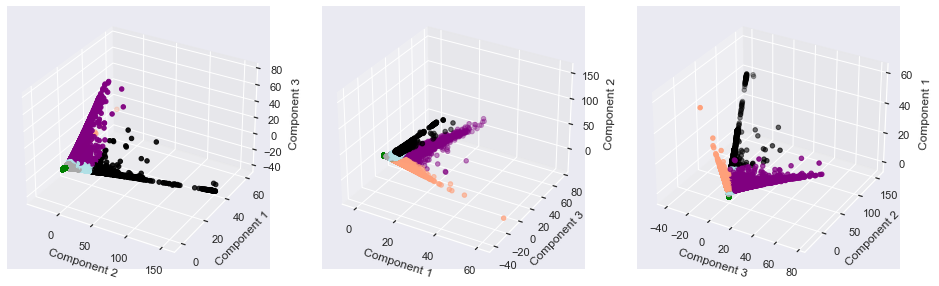

In [39]:
# 3D plots with the 3 components on different axes to help visulize
_3d_plots(full_df_segm_pca_kmeans,cluster_value = 6)

In [22]:
# grab all the individual clusters flag user percent usage
temp_array = all_flag_info(full_df_segm_pca_kmeans,cluster_value_ = 6)

# put it into a nice dataframe for viewing
Flag_describe = pd.DataFrame(temp_array,columns = ['Cluster','ADDTOWATCHLIST_FLAG','FAVORITECHANNEL_FLAG','SEARCHSTART_FLAG',
       'LIVEL2NAV_FLAG', 'VODL2NAV_FLAG', 'WATCHNOW_FLAG', 'BACKTOGUIDE_FLAG',
       'FEATURE_FLAG'])

# output the describe
Flag_describe#.to_csv('user_percent.csv')

,Cluster,ADDTOWATCHLIST_FLAG,FAVORITECHANNEL_FLAG,SEARCHSTART_FLAG,LIVEL2NAV_FLAG,VODL2NAV_FLAG,WATCHNOW_FLAG,BACKTOGUIDE_FLAG,FEATURE_FLAG
0,0,3.32,4.82,14.64,45.26,23.35,21.23,38.28,68.91
1,1,9.84,20.04,27.60,83.36,41.82,30.09,71.12,93.01
2,2,7.12,12.36,22.75,73.67,36.55,28.51,61.15,88.21
3,3,1.59,6.18,5.38,35.06,7.67,5.88,27.49,43.43
4,4,27.62,20.57,55.15,67.29,87.66,87.89,64.46,97.78
5,5,1.86,2.47,11.99,30.11,15.02,7.83,26.14,54.42


### New vs Return comparison

In [43]:
user_status_comp = categorical_var_index(full_df_segm_pca_kmeans,mid_granular_col='Segment K-Means PCA 6',
                      most_granular_col='USER_STATUS',count_col='CLIENT_ID')

user_status_comp

,Segment K-Means PCA 6,USER_STATUS,Segment K-Means PCA 6_TTL,USER_STATUS_TTL,Segment K-Means PCA 6_USER_STATUS_TTL,All_TTL,pct_of_seg,pct_of_all,index
0,0,New User,2527909,868266,361487,5947349,14.30,14.60,0.98
1,1,New User,395008,868266,3802,5947349,0.96,14.60,0.07
2,2,New User,798759,868266,34676,5947349,4.34,14.60,0.30
3,3,New User,1004,868266,26,5947349,2.59,14.60,0.18
4,4,New User,28788,868266,1718,5947349,5.97,14.60,0.41
5,5,New User,2195881,868266,466557,5947349,21.25,14.60,1.46
6,0,Return User,2527909,5079083,2166422,5947349,85.70,85.40,1.00
7,1,Return User,395008,5079083,391206,5947349,99.04,85.40,1.16
8,2,Return User,798759,5079083,764083,5947349,95.66,85.40,1.12
9,3,Return User,1004,5079083,978,5947349,97.41,85.40,1.14


### Tenure bin comparisons

In [23]:
# creating bins for putting users in based on tenure
bins = [-np.inf, 0, 30, 90, 180, 365, np.inf]

# pd.cut will segment the users into their appropraite bins
full_df_segm_pca_kmeans['TENURES'] = pd.cut(full_df_segm_pca_kmeans['TENURE_DAYS'], bins)

In [24]:
tenure_comp = categorical_var_index(full_df_segm_pca_kmeans,mid_granular_col='Segment K-Means PCA 6',
                      most_granular_col='TENURES',count_col='CLIENT_ID')

In [25]:
tenure_comp#['pct_of_all'].unique()

,Segment K-Means PCA 6,TENURES,Segment K-Means PCA 6_TTL,TENURES_TTL,Segment K-Means PCA 6_TENURES_TTL,All_TTL,pct_of_seg,pct_of_all,index
0,0,"(-inf, 0.0]",2527909,544581,151427,5947349,5.99,9.16,0.65
1,1,"(-inf, 0.0]",395008,544581,0,5947349,0.00,9.16,0.00
2,2,"(-inf, 0.0]",798759,544581,0,5947349,0.00,9.16,0.00
3,3,"(-inf, 0.0]",1004,544581,1,5947349,0.10,9.16,0.01
4,4,"(-inf, 0.0]",28788,544581,0,5947349,0.00,9.16,0.00
5,5,"(-inf, 0.0]",2195881,544581,393153,5947349,17.90,9.16,1.96
6,0,"(0.0, 30.0]",2527909,441407,262924,5947349,10.40,7.42,1.40
7,1,"(0.0, 30.0]",395008,441407,4043,5947349,1.02,7.42,0.14
8,2,"(0.0, 30.0]",798759,441407,39923,5947349,5.00,7.42,0.67
9,3,"(0.0, 30.0]",1004,441407,32,5947349,3.19,7.42,0.43


### Categorical comparisons

In [26]:
category_comps = categorical_var_index(full_df_segm_pca_kmeans,mid_granular_col='Segment K-Means PCA 6',
                      most_granular_col='MOST_WATCHED_CATEGORY',count_col='CLIENT_ID')

In [27]:
category_comps #.sort_values(by=['Segment K-Means PCA 6','Segment K-Means PCA 6_most_watched_category_TTL'],ascending=False).head(35)

,Segment K-Means PCA 6,MOST_WATCHED_CATEGORY,Segment K-Means PCA 6_TTL,MOST_WATCHED_CATEGORY_TTL,Segment K-Means PCA 6_MOST_WATCHED_CATEGORY_TTL,All_TTL,pct_of_seg,pct_of_all,index
0,0,Classic TV,2527909,543744,224149,5947349,8.87,9.14,0.97
1,1,Classic TV,395008,543744,86256,5947349,21.84,9.14,2.39
2,2,Classic TV,798759,543744,127041,5947349,15.90,9.14,1.74
3,3,Classic TV,1004,543744,200,5947349,19.92,9.14,2.18
4,4,Classic TV,28788,543744,2010,5947349,6.98,9.14,0.76
...,...,...,...,...,...,...,...,...,...
92,1,VOD,395008,1382323,5233,5947349,1.32,23.24,0.06
93,2,VOD,798759,1382323,92370,5947349,11.56,23.24,0.50
94,3,VOD,1004,1382323,5,5947349,0.50,23.24,0.02
95,4,VOD,28788,1382323,22778,5947349,79.12,23.24,3.40


### Channel Comparisons

In [51]:
channel_comps = categorical_var_index(full_df_segm_pca_kmeans,mid_granular_col='Segment K-Means PCA 6',
                      most_granular_col='MOST_WATCHED_CHANNEL',count_col='CLIENT_ID')

In [52]:
channel_comps #.sort_values(by=['Segment K-Means PCA 6','index'],ascending=[False,False]).head(20)

,Segment K-Means PCA 6,MOST_WATCHED_CHANNEL,Segment K-Means PCA 6_TTL,MOST_WATCHED_CHANNEL_TTL,Segment K-Means PCA 6_MOST_WATCHED_CHANNEL_TTL,All_TTL,pct_of_seg,pct_of_all,index
0,1,2002 Live Stream Test,395008,1,1,5947349,0.00,0.00,15.06
1,0,48 Hours,2527909,32699,14029,5947349,0.55,0.55,1.01
2,1,48 Hours,395008,32699,5272,5947349,1.33,0.55,2.43
3,2,48 Hours,798759,32699,8437,5947349,1.06,0.55,1.92
4,3,48 Hours,1004,32699,7,5947349,0.70,0.55,1.27
...,...,...,...,...,...,...,...,...,...
1742,5,beIN SPORTS XTRA en español,2195881,789,593,5947349,0.03,0.01,2.04
1743,0,pocket.watch,2527909,3241,1140,5947349,0.05,0.05,0.83
1744,1,pocket.watch,395008,3241,109,5947349,0.03,0.05,0.51
1745,2,pocket.watch,798759,3241,315,5947349,0.04,0.05,0.72


### UTM comparisons

In [28]:
# SQL for this utm csv file is in the appendix
utm_may_df = pd.read_csv('utm_may_data.csv', index_col = False)

In [29]:
len(utm_may_df)
utm_may_df.columns

Index(['Unnamed: 0', 'CLIENT_ID', 'UTM_CONTENT', 'UTM_MEDIUM', 'EPISODE_ID',
       'EPISODE_NAME'],
      dtype='object')

In [30]:
# concatenating the content codes for those with them
utm_may_df['content_concat'] = utm_may_df[utm_may_df['UTM_CONTENT'].notnull()].groupby(['CLIENT_ID'])['UTM_CONTENT'].transform(lambda x: ', '.join(x))

In [31]:
# separate utm_df with just client_id and content_concat for dropping duplicates
temp_utm_content_df = utm_may_df[['CLIENT_ID','content_concat']]
temp_utm_medium_df = utm_may_df[['CLIENT_ID','UTM_MEDIUM']]

# dropping duplicates
temp_utm_content_df = temp_utm_content_df.drop_duplicates().reset_index(drop = True)
temp_utm_medium_df  = temp_utm_medium_df.drop_duplicates().reset_index(drop = True)

# only users with null
NA_users_content = temp_utm_content_df[temp_utm_content_df['content_concat'].isna()]
NA_users_medium = temp_utm_medium_df[temp_utm_medium_df['UTM_MEDIUM'].isna()]

# only users with non null
val_users_content = temp_utm_content_df[temp_utm_content_df['content_concat'].notnull()]
val_users_medium = temp_utm_medium_df[temp_utm_medium_df['UTM_MEDIUM'].notnull()]

In [32]:
# doing an outer join to only get users one row each bec some users had two rows, one with the concat and one with NA
temp_utm_content_final = pd.merge(val_users_content,NA_users_content,on='CLIENT_ID',how='outer')
temp_utm_medium_final = pd.merge(val_users_medium,NA_users_medium,on='CLIENT_ID',how='outer')

In [33]:
temp_utm_medium_final.head(3)

,CLIENT_ID,UTM_MEDIUM_x,UTM_MEDIUM_y
0,fb414a86-69d9-526c-a490-290042d19369,searchintegration,NaN
1,adfe46bd-3f14-59c9-bca8-9d70b1ba952c,searchintegration,NaN
2,8634d4c5-80f2-5e1f-8848-e544302e006a,searchintegration,NaN


In [34]:
temp_utm_content_final = temp_utm_content_final[['CLIENT_ID','content_concat_x']]
temp_utm_medium_final = temp_utm_medium_final[['CLIENT_ID','UTM_MEDIUM_x']]

In [35]:
temp_full_df = full_df_segm_pca_kmeans

In [36]:
full_df_w_utm = pd.merge(temp_full_df,temp_utm_content_final, on='CLIENT_ID', how= 'left')

In [37]:
full_df_w_utm = pd.merge(full_df_w_utm,temp_utm_medium_final, on='CLIENT_ID', how= 'left')

In [38]:
full_df_w_utm.head(2)

,CLIENT_ID,MONTH,MOST_WATCHED_CHANNEL,MOST_WATCHED_CATEGORY,TOTAL_TVMS,USER_STATUS,LINEAR_TVMS,VOD_TVMS,ADDTOWATCHLIST_FLAG,FAVORITECHANNEL_FLAG,...,UNIQUE_DAYS,DAY_PERCENT,log_transform_TOTAL_TVMS,Component 1,Component 2,Component 3,Segment K-Means PCA 6,TENURES,content_concat_x,UTM_MEDIUM_x
0,90f4ffe9-6a5f-51fa-993c-6c19a83aad44,2022-05-01,Pluto TV Horror,Movies,92.75,Return User,92.75,0.00,0.00,0.00,...,2.00,0.06,4.53,-0.59,0.19,-0.09,0,"(90.0, 180.0]","569546031a619b8f07ce6e25, 5ca673e0d0bd6c2689c9...",searchintegration
1,90f50165-1f5a-52fa-b736-8273eedec093,2022-05-01,Pluto TV Comedy,Movies,411.47,Return User,411.47,0.00,0.00,0.00,...,4.00,0.13,6.02,-0.02,0.08,-0.21,0,"(90.0, 180.0]",NaN,NaN


In [39]:
full_df_w_utm.rename(columns = {'content_concat_x':'UTM_CONTENT_CONCAT','UTM_MEDIUM_x':'UTM_MEDIUM'}, inplace = True)

In [40]:
utm_medium_comps = categorical_var_index(full_df_w_utm,mid_granular_col='Segment K-Means PCA 6',
                      most_granular_col='UTM_MEDIUM',count_col='CLIENT_ID')

In [41]:
utm_medium_comps#.sort_values(by=['Segment K-Means PCA 6','content_concat_x_TTL'],ascending=False)

,Segment K-Means PCA 6,UTM_MEDIUM,Segment K-Means PCA 6_TTL,UTM_MEDIUM_TTL,Segment K-Means PCA 6_UTM_MEDIUM_TTL,All_TTL,pct_of_seg,pct_of_all,index
0,0,searchintegration,2527909,1582888,709100,5947349,28.05,26.62,1.05
1,1,searchintegration,395008,1582888,28178,5947349,7.13,26.62,0.27
2,2,searchintegration,798759,1582888,102560,5947349,12.84,26.62,0.48
3,3,searchintegration,1004,1582888,29,5947349,2.89,26.62,0.11
4,4,searchintegration,28788,1582888,9923,5947349,34.47,26.62,1.30
5,5,searchintegration,2195881,1582888,733098,5947349,33.39,26.62,1.25


### Renaming segments

In [42]:
# making all columns capital
full_df_w_utm.columns = map(lambda x: str(x).upper(), full_df_w_utm.columns)

In [43]:
# Renaming the Segments to what we named them in the presentation
# 0 - Discovering 
# 1 - Power 
# 2 - Regular 
# 3 - Always On
# 4 - Heavy VOD
# 5 - Initial Evaluation 

In [44]:
full_df_w_utm.loc[full_df_w_utm["SEGMENT K-MEANS PCA 6"] == 0, "SEGMENT K-MEANS PCA 6"] = 'Discovering'
full_df_w_utm.loc[full_df_w_utm["SEGMENT K-MEANS PCA 6"] == 1, "SEGMENT K-MEANS PCA 6"] = 'Power'
full_df_w_utm.loc[full_df_w_utm["SEGMENT K-MEANS PCA 6"] == 2, "SEGMENT K-MEANS PCA 6"] = 'Regular'
full_df_w_utm.loc[full_df_w_utm["SEGMENT K-MEANS PCA 6"] == 3, "SEGMENT K-MEANS PCA 6"] = 'Always On'
full_df_w_utm.loc[full_df_w_utm["SEGMENT K-MEANS PCA 6"] == 4, "SEGMENT K-MEANS PCA 6"] = 'Heavy VOD'
full_df_w_utm.loc[full_df_w_utm["SEGMENT K-MEANS PCA 6"] == 5, "SEGMENT K-MEANS PCA 6"] = 'Initial Evaluation'

In [45]:
full_df_w_utm.head(5)

,CLIENT_ID,MONTH,MOST_WATCHED_CHANNEL,MOST_WATCHED_CATEGORY,TOTAL_TVMS,USER_STATUS,LINEAR_TVMS,VOD_TVMS,ADDTOWATCHLIST_FLAG,FAVORITECHANNEL_FLAG,...,UNIQUE_DAYS,DAY_PERCENT,LOG_TRANSFORM_TOTAL_TVMS,COMPONENT 1,COMPONENT 2,COMPONENT 3,SEGMENT K-MEANS PCA 6,TENURES,UTM_CONTENT_CONCAT,UTM_MEDIUM
0,90f4ffe9-6a5f-51fa-993c-6c19a83aad44,2022-05-01,Pluto TV Horror,Movies,92.75,Return User,92.75,0.00,0.00,0.00,...,2.00,0.06,4.53,-0.59,0.19,-0.09,Discovering,"(90.0, 180.0]","569546031a619b8f07ce6e25, 5ca673e0d0bd6c2689c9...",searchintegration
1,90f50165-1f5a-52fa-b736-8273eedec093,2022-05-01,Pluto TV Comedy,Movies,411.47,Return User,411.47,0.00,0.00,0.00,...,4.00,0.13,6.02,-0.02,0.08,-0.21,Discovering,"(90.0, 180.0]",NaN,NaN
2,90f50473-54ac-5fb0-95f0-e6ecf1155071,2022-05-01,VOD,VOD,1.23,Return User,0.00,1.23,0.00,0.00,...,1.00,0.03,0.21,-1.56,-0.29,0.21,Initial Evaluation,"(365.0, inf]",5db1edfedc8a83b8e29f99bf,searchintegration
3,90f50fdc-dddd-557a-b6fd-085f0551173e,2022-05-01,Three's Company,Classic TV,698.88,Return User,698.88,0.00,0.00,0.00,...,4.00,0.13,6.55,0.14,0.20,-0.27,Discovering,"(365.0, inf]",NaN,NaN
4,90f51361-5b1f-5d51-b987-1f4012c34352,2022-05-01,FailArmy,Comedy,"1,082.08",Return User,"1,082.08",0.00,0.00,1.00,...,9.00,0.29,6.99,0.71,0.04,-0.39,Discovering,"(365.0, inf]",NaN,NaN


In [54]:
full_df_w_utm.to_csv('may_complete_df.csv')

In [47]:
#full_df_w_utm = full_df_w_utm.drop(['Segment_K_Means_PCA_5','Segment K-Means PCA 5'],axis = 1)

### Writing final dataframe to Snowflake

In [48]:
import pandas
from snowflake.connector.pandas_tools import write_pandas
import snowflake.connector
import configparser
from sqlalchemy import create_engine
from snowflake.connector.pandas_tools import pd_writer

In [49]:
# use this to access your login crednetials
config = configparser.ConfigParser()
config.read(r'C:\Users\troutg\Documents\config.ini')

user = config['sf_login']['user']
pswd = config['sf_login']['pswd']

In [50]:
#Create connection to Snowflake using your account and user
account_identifier = 'plutotv_prod.us-east-1'
user = user
password = pswd
database_name = 'SANDBOX'
schema_name = 'ANALYSIS_PRODUCT'
warehouse_name = 'BI_WH_ANALYST_4XL_1'
role_name = 'BI_ANALYST'

#'snowflake://<user_login_name>:<password>@<account_identifier>/<database_name>/<schema_name>?warehouse=<warehouse_name>&role=<role_name>'

#conn_string = f"snowflake://{user}:{password}@{account_identifier}/{database_name}/{schema_name}?warehouse={warehouse_name}&{role_name}"
conn_string = f"snowflake://{user}:{password}@{account_identifier}/{database_name}/{schema_name}?warehouse={warehouse_name}"
engine = create_engine(conn_string)

In [51]:
# ALL columns NEED to be uppercase
full_df_w_utm.columns = map(lambda x: str(x).upper(), full_df_w_utm.columns)

In [53]:
table_name = 'SEGMENTATION_2_MAY_DATA_GT_080322'

#What to do if the table exists? replace, append, or fail?

if_exists = 'replace'

#Write the data to Snowflake, using pd_writer to speed up loading

with engine.connect() as con:
        full_df_w_utm.to_sql(name=table_name.lower(), con=con, index=False, if_exists=if_exists, method=pd_writer)

### APPENDIX

#### SQL for May data

In [ ]:
# # Below is the query pulling from the 2 tables that were created by the two creation statements above

# select us.client_id
#        ,us.month
#        ,most_Watched_Channel
#        ,most_watched_category
#        ,total_tvms
#        ,user_status
#        ,LINEAR_TVMS
#        ,VOD_TVMS
#        ,ADDTOWATCHLIST_FLAG
#        ,FAVORITECHANNEL_FLAG
#        ,SEARCHSTART_FLAG
#        ,LIVEL2NAV_FLAG
#        ,VODL2NAV_FLAG
#        ,WATCHNOW_FLAG
#        ,BACKTOGUIDE_FLAG
#        ,FEATURE_FLAG
#        ,tenure_days
#        ,avg_days_apart
#        ,avg_session_duration
#        ,monthly_avg_session_duration
#        ,frequency
#        ,monthly_frequency
#        ,unique_days
#        ,day_percent
# from SANDBOX.ANALYSIS_PRODUCT.USER_SEGMENTATIONS_UPDATED us
# JOIN SANDBOX.ANALYSIS_PRODUCT.VIEWERSHIP_PATTERNS vp on vp.client_id = us.client_id
# where 1=1
# and us.MONTH = '2022-05-01'
# and vp.MONTH = '2022-05-01'

#### Cells used for importing the may data and converting it to a csv 

In [57]:
# import configparser
# import snowflake.connector

In [58]:
# # use this to access your login crednetials
# config = configparser.ConfigParser()
# config.read(r'C:\Users\troutg\Documents\config.ini')

# user = config['sf_login']['user']
# pswd = config['sf_login']['pswd']

In [59]:
# #create the connection to your direct SCHEMA
# #when you run this you will need to verify with your MFA
# con = snowflake.connector.connect(
#     user=user,
#     password=pswd,
#     account='plutotv_prod.us-east-1',
#     database='SANDBOX',
#     schema='ANALYSIS_PRODUCT'
# )

In [53]:
# cur = con.cursor()

# # execute the below query to get the raw data
# cur.execute("USE WAREHOUSE BI_WH_ANALYST_4XL_1;")
# cur.execute("""
# select us.client_id
#        ,us.month
#        ,most_Watched_Channel
#        ,most_watched_category
#        ,total_tvms
#        ,user_status
#        ,LINEAR_TVMS
#        ,VOD_TVMS
#        ,ADDTOWATCHLIST_FLAG
#        ,FAVORITECHANNEL_FLAG
#        ,SEARCHSTART_FLAG
#        ,LIVEL2NAV_FLAG
#        ,VODL2NAV_FLAG
#        ,WATCHNOW_FLAG
#        ,BACKTOGUIDE_FLAG
#        ,FEATURE_FLAG
#        ,tenure_days
#        ,avg_days_apart
#        ,avg_session_duration
#        ,monthly_avg_session_duration
#        ,frequency
#        ,monthly_frequency
#        ,unique_days
#        ,day_percent
# from SANDBOX.ANALYSIS_PRODUCT.USER_SEGMENTATIONS_UPDATED us
# JOIN SANDBOX.ANALYSIS_PRODUCT.VIEWERSHIP_PATTERNS vp on vp.client_id = us.client_id
# where 1=1
# and us.MONTH = '2022-05-01'
# and vp.MONTH = '2022-05-01'
#             """)

In [6]:
# # the following four lines get the data into a dataframe
# query_id = cur.sfqid

# cur.get_results_from_sfqid(query_id)

# results = cur.fetchall()

In [ ]:
#column_titles = [x[0] for x in cur.description]

In [11]:
#may_df = pd.DataFrame(results, columns =column_titles)

In [13]:
#may_df.to_csv('may_df.csv')

#### Cells used for importing may utm data and converitng to csv

In [ ]:
# UTM data import

In [2]:

# cur = con.cursor()

# # execute the below query to get the raw data
# cur.execute("USE WAREHOUSE BI_WH_ANALYST_4XL_1;")
# cur.execute("""
# SELECT 
#         distinct 
#         utm.client_id
#         ,utm_content
#         ,utm_medium
#         ,ced.episode_id
#         ,ced.episode_name
# FROM SANDBOX.ANALYSIS_PRODUCT.UTM_DATA_SUB utm
# LEFT JOIN ODIN_PRD.DW_ODIN.CMS_EPISODE_DIM ced on utm.utm_content = ced.episode_id
# JOIN ODIN_PRD.RPT.ALL_HOURLY_TVS_AGG agg on agg.client_id = utm.client_id
# where 1=1
#   and GEO_ALIGNED_FLAG = True
#   and EP_SOURCES_ALIGNED_FLAG = True
#   and TIMELINE_ALIGNED_FLAG = True
#   and country = 'US'
#   and date_trunc('day',VIDEO_SEGMENT_BEGIN_UTC) between '2022-05-01' and '2022-05-31'
#   and lower(agg.app_name) = 'roku'
# AND month = '2022-05-01'
#             """)

NameError: name 'con' is not defined

In [63]:
# the following four lines get the data into a dataframe
query_id = cur.sfqid

cur.get_results_from_sfqid(query_id)

results = cur.fetchall()

In [73]:
# utm_may_data = pd.DataFrame(results, columns = ['CLIENT_ID', 'UTM_CONTENT', 'UTM_MEDIUM', 'EPISODE_ID', 'EPISODE_NAME'])

In [75]:
# cur.close()
# con.close()

In [76]:
# utm_may_data.to_csv('utm_may_data.csv')